In [5]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def load_transaction_data(file):
    df = pd.read_csv(file)
    header_string = "dl_cd,txn_dt,stlmnt_dt,dl_tm,bsns_tm,bond_cd,bnds_nm,net_prc,yld_to_mrty,nmnl_vol,amnt,acrd_intrst,totl_acrd_intrst,all_prc,stlmnt_amnt,ttm_yrly,byr_qt_cd,byr_instn_cd,byr_cfets_instn_cd,byr_instn_cn_full_nm,byr_instn_cn_shrt_nm,byr_instn_en_shrt_nm,byr_trdr_nm,byr_adrs,byr_trdr_fax,byr_lgl_rprsntv,byr_trdr_tel,buy_side_trdng_acnt_cd,byr_cptl_bnk_nm,byr_cptl_acnt_no,byr_pymnt_sys_cd,byr_dpst_acnt_nm,buy_side_dpst_cd,byr_trd_acnt_cfets_cd,byr_trd_acnt_cn_full_nm,byr_trd_acnt_cn_shrt_nm,byr_trd_acnt_en_shrt_nm,byr_cptl_acnt_nm,byr_trd_acnt_en_full_nm,slr_qt_cd,slr_instn_cd,slr_cfets_instn_cd,slr_instn_cn_full_nm,slr_instn_cn_shrt_nm,slr_instn_en_shrt_nm,slr_trdr_cd,slr_trdr_nm,slr_adrs,slr_trdr_fax,slr_lgl_rprsntv,slr_trdr_tel,sell_side_trdng_acnt_cd,slr_cptl_bnk_nm,slr_cptl_acnt_no,slr_pymnt_sys_cd,slr_dpst_acnt_nm,sell_side_dpst_acnt,slr_trd_acnt_cfets_cd,slr_trd_acnt_cn_full_nm,slr_trd_acnt_cn_shrt_nm,slr_trd_acnt_en_shrt_nm,slr_cptl_acnt_nm,slr_trd_acnt_en_full_nm,crt_tm,upd_tm"
    # 使用split()方法将字符串转换为列表
    header_list = header_string.split(',')
    return df[header_list]

def merge_transactions(df, window=1):
    # 将日期转换为 datetime 对象
    df['date'] = pd.to_datetime(df['date'])

    # 根据日期和其他关键列对数据进行排序
    df = df.sort_values(by=['date', 'buyer', 'seller'])
    merged_transactions = []
    current_transaction = None
    
    for _, row in df.iterrows():
        if current_transaction is None:
            current_transaction = row
            continue
        
        if (row['date'] - current_transaction['date']).days <= window:
            if row['buyer'] == current_transaction['buyer'] and row['seller'] == current_transaction['seller'] and row['price'] == current_transaction['price']:
                current_transaction['volume'] += row['volume']
            else:
                merged_transactions.append(current_transaction)
                current_transaction = row
        else:
            merged_transactions.append(current_transaction)
            current_transaction = row
            
    if current_transaction is not None:
        merged_transactions.append(current_transaction)
    
    return pd.DataFrame(merged_transactions)

def preprocess_data(df):
    # 设置 Pandas 显示选项
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)

    # 将交易时间列转换为 datetime 对象
    df['dl_tm'] = pd.to_datetime(df['dl_tm'])

    # 将字符串列转换为字符串类型
    df['byr_instn_cn_full_nm'] = df['byr_instn_cn_full_nm'].astype(str)
    df['slr_instn_cn_full_nm'] = df['slr_instn_cn_full_nm'].astype(str)
    df['byr_trdr_nm'] = df['byr_trdr_nm'].astype(str)
    df['slr_trdr_nm'] = df['slr_trdr_nm'].astype(str)

    # 将购买和销售机构合并为一个列
    df['instn'] = df['byr_instn_cn_full_nm'].str.cat(df['slr_instn_cn_full_nm'], sep=',')

    # 计算每个月每个机构的交易次数
    df['byr_instn_cn_full_nm'] = df['byr_instn_cn_full_nm'].str[:6].str.cat(df['byr_trdr_nm'], sep='')
    df['slr_instn_cn_full_nm'] = df['slr_instn_cn_full_nm'].str[:6].str.cat(df['slr_trdr_nm'], sep='')
    df['byr_trdr_nm'] = df['byr_trdr_nm'].str.ljust(4)
    df['slr_trdr_nm'] = df['slr_trdr_nm'].str.ljust(4)
    df['nmnl_vol'] = np.int64(df["nmnl_vol"]/10000000)
    df['net_prc'] = (df["net_prc"]).round(2)
    # 提取需要的列
    result = df[['dl_tm', 'stlmnt_dt', 'slr_instn_cn_full_nm', 'byr_instn_cn_full_nm', 'nmnl_vol', 'net_prc', 'byr_trdr_nm', 'slr_trdr_nm']]
    # 重命名列以使其更易读
    result = result.rename(columns={"dl_tm" :'date_dl', "stlmnt_dt" :'date', 'byr_instn_cn_full_nm':'buyer', 'slr_instn_cn_full_nm':"seller",  'instn': 'Institution', 'nmnl_vol': 'volume', 'net_prc': "price", 'byr_cd':'byr_instn_cd', 'slr_cd':'slr_instn_cd'})
    return result
    return merge_transactions(result)

/Users/dennis/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


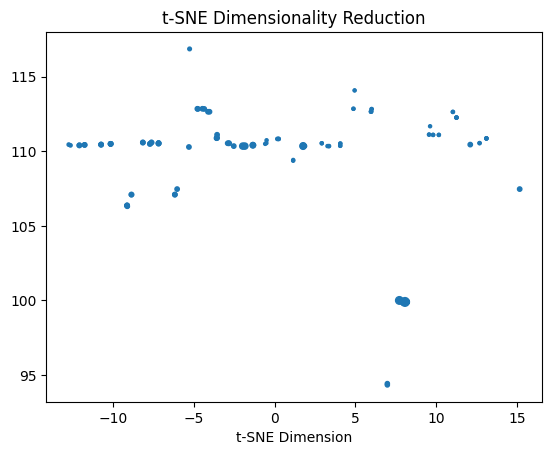

In [6]:
# 示例数据
file = 'static/chain_data/bond_2005496_2006_2402.csv'
df_all = load_transaction_data(file)
df_processed = preprocess_data(df_all)
# 提取年、月、日信息
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['year'] = df_processed['date'].dt.year
df_processed['month'] = df_processed['date'].dt.month
df_processed['day'] = df_processed['date'].dt.day
# feature_list = ['seller', 'buyer', 'byr_trdr_nm', 'slr_trdr_nm', 'volume', 'price', 'year', 'month', 'day']
feature_list = ['volume', 'price', 'year', 'month', 'day']
df_feature = df_processed[feature_list]


def get_tsne_data(df, feature_list, n_components=1):
  # 对分类特征进行 one-hot 编码
  encoder = OneHotEncoder(sparse=False)
  encoded_features = encoder.fit_transform(df[feature_list])
  # 使用 t-SNE 进行降维
  tsne = TSNE(n_components, random_state=42)
  transformed_data = tsne.fit_transform(encoded_features)
  return transformed_data

# 绘制散点图
transformed_data = get_tsne_data(df_feature, feature_list)
plt.scatter(transformed_data, df_processed['price'], s=df_processed['volume'])
plt.xlabel('t-SNE Dimension')
plt.title('t-SNE Dimensionality Reduction')
plt.show()


In [7]:
df_processed['y_pos'] = transformed_data
df_processed_sorted = df_processed.sort_values(by='y_pos')

In [8]:
df_processed_sorted

,date_dl,date,seller,buyer,volume,price,byr_trdr_nm,slr_trdr_nm,year,month,day,y_pos
15,2023-07-04 16:10:54+08:00,2023-07-05,川财证券有限高欣,广东南海农村曹兆全,6,110.44,曹兆全,高欣,2023,7,5,-12.728163
18,2023-07-04 15:38:44+08:00,2023-07-05,兴业银行股份陈颖,川财证券有限赖颂怡,6,110.39,赖颂怡,陈颖,2023,7,5,-12.623782
17,2023-07-04 15:39:11+08:00,2023-07-05,兴业银行股份陈颖,川财证券有限赖颂怡,10,110.39,赖颂怡,陈颖,2023,7,5,-12.072901
16,2023-07-04 15:39:00+08:00,2023-07-05,兴业银行股份陈颖,川财证券有限赖颂怡,10,110.39,赖颂怡,陈颖,2023,7,5,-12.071919
24,2023-07-05 14:56:10+08:00,2023-07-05,川财证券有限李丹,福建海峡银行彭席席,10,110.42,彭席席,李丹,2023,7,5,-11.747543
23,2023-07-05 14:56:10+08:00,2023-07-05,川财证券有限李丹,福建海峡银行彭席席,10,110.42,彭席席,李丹,2023,7,5,-11.747528
22,2023-07-06 13:45:50+08:00,2023-07-06,川财证券有限李丹,中国太平洋人孟祥钧,10,110.44,孟祥钧,李丹,2023,7,6,-10.728271
32,2023-07-06 13:30:13+08:00,2023-07-06,交通银行股份何嘉隆,川财证券有限李丹,10,110.44,李丹,何嘉隆,2023,7,6,-10.728271
25,2023-07-06 13:46:20+08:00,2023-07-06,川财证券有限李丹,中国太平洋人孟祥钧,10,110.44,孟祥钧,李丹,2023,7,6,-10.728271
21,2023-07-05 15:22:55+08:00,2023-07-06,兴业银行股份陈颖,川财证券有限赖颂怡,10,110.49,赖颂怡,陈颖,2023,7,6,-10.139488
